# Damped harmonic oscillator using PINNs


In this notebook, we'll replicate the code and animations in [this video](https://youtu.be/IDIv92Z6Qvc?si=EKxJZZeUdce1jgF1) by remixing [this notebook](https://github.com/benmoseley/DLSC-2023/blob/main/lecture-5/PINN%20demo.ipynb) to solve simulation and inversion problems related to the damped harmonic oscillator. Actually I'm not very good at making animations, so we'll just use the animation code in [this notebook](https://github.com/benmoseley/harmonic-oscillator-pinn/blob/main/Harmonic%20oscillator%20PINN.ipynb) :)


---

In [177]:
import numpy as np
import torch
import torch.nn as nn
from PIL import Image as PILImage
from IPython.display import display, Image, HTML
import matplotlib.pyplot as plt
from typing import Callable, List, Union

In [141]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device:", device)
# elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
#     device = torch.device("mps")
#     print("Using MPS device:", device)
else:
    device = torch.device("cpu")
    print("Using CPU device:", device)

Using CPU device: cpu


In [142]:
def save_gif_PIL(outfile: str, files: List[str], fps: int=5, loop: int=0) -> None:
    "Helper function for saving GIFs"
    imgs = [PILImage.open(file) for file in files]
    print(f"Saving {len(imgs)} frames to {outfile}")
    imgs[0].save(fp=outfile, format="GIF", append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

Suppose we have a spring with a spring constant $k$ and a mass $m$ attached to it. The system is subject to damping, characterized by a damping coefficient $\mu$. The distance from equilibrium as a function of time is $u(t)$. 

The inertial force of the mass is given by Newton's Second Law:
\begin{equation*}
F_{\text{inertia}} = m \frac{d^2u}{dt^2}
\end{equation*}

The restoring force exerted by the spring is given by Hooke's Law:

\begin{equation*}
F_{\text{spring}} = -ku
\end{equation*}

The damping force opposing the velocity of the mass is given by:
\begin{equation*}
F_{\text{damping}} = -\mu \frac{du}{dt}
\end{equation*}

By Newton's Second Law, we know that the sum of all forces on the mass should be equal to the mass times the acceleration:
\begin{align*}
F_{\text{inertia}} &= F_{\text{spring}} + F_{\text{damping}} \\
m \frac{d^2u}{dt^2} &= -ku -\mu \frac{du}{dt} \\
m \frac{d^2u}{dt^2} &+ \mu \frac{du}{dt} + ku = 0 \\
\end{align*}

We can factor out $u$

$$
\left(m \frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right) \big[u \big] = 0 \\
$$

to put the equation in the form

$$
\mathcal{D}[u(x, t)] = f(x, t)
$$

where $\mathcal{D}$ is some differential operator, and $f(x, t)$ represents the external forcing function or input.

We will focus on solving the problem in the under-damped state, i.e. where the oscillation is slowly damped by friction 

Mathematically, this occurs when:
\begin{equation*}
\delta < \omega_0~,~~~~~\mathrm{where}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
\end{equation*}

Furthermore, we consider the following initial conditions of the system:
\begin{equation*}
u(t=0) = 1, \quad \dfrac{d u}{d t}(t=0) = 0.
\end{equation*}

meaning that the mass starts extended at rest. For this particular case, the exact solution is known and given by:
\begin{equation*}
u(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
\end{equation*}

For a more detailed mathematical description of the harmonic oscillator, check out [this blog post](https://beltoforion.de/en/harmonic_oscillator/).


In [143]:
def exact_solution(d: float, w0: float, t: float) -> float:
    "Defines the analytical solution to the under-damped harmonic oscillator problem above."
    assert d < w0
    w = np.sqrt(w0**2 - d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi +w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u

## Workflow overview

There are **two scientific tasks** related to the harmonic oscillator we will use a PINN for:

>First, we will **simulate** the system using a PINN, given its initial conditions.

>Second, we will **invert** for underlying parameters of the system using a PINN, given some noisy observations of the oscillator's displacement.

>Third, we will compare the performance of a PINN and an MLP at learning an oscillatory pattern from partial data.

---

## Task 1: train a PINN to simulate the system

---

### Theory

Using traditional PDE solving techniques (finite difference, finite element, etc.), we have to discretize the input and output space. This means that the output will be a vector (or maybe matrix) of values corresponding to the PDE solution at the given input points. Then to craft a higher-precision solution, we will necessarily need to feed in more input points, requiring more computation.

PINNs are cool because the trained neural network is an approximatino of the PDE solution itself. This means that you actually get a continuous function out that can be queried over any point within the domain. Note, however, that PINNs may take a long time to train depending on the dimensionality of the input space, and may not be required for simple PDEs... like the one above :)

A PINN is trained to directly approximate the solution to the differential equation, i.e.

$$
N\!N(x, t;\theta) \approx u(x, t),
$$

given a PDE and its boundary/initial conditions

\begin{align*}
\mathcal{D}[u(x, t)] &= f(x, t), \quad x \in \Omega \subset \mathbb{R}^d \\
B_k[u(x, t)] &= g_k(x, t), \quad x \in \Gamma_k \subset \partial \Omega
\end{align*}

where:
- $\partial \Omega$ is the boundary of domain $\Omega$, and $\Gamma_k$ are specific boundary regions within $\partial \Omega$
- $\mathcal{D}$ is a differential operator that governs the behavior of the system
- $B_k$ are a set of boundary operators that impose specific conditions at the boundaries of the domain $\Omega$, $\partial \Omega$
- $f(x, t)$ is a source term or function that represents any external influence affecting the solution within the domain $\Omega$
- $g_k(x, t)$ specifies the conditions imposed by the boundary operators at the boundaries $\Gamma_k$
- $u(x, t)$ is the solution to the PDE

We will actually rewrite these as

\begin{align*}
\mathcal{D}[u(x, t)] - f(x, t) &= 0 \\
B_k[u(x, t)] - g_k(x, t) &= 0
\end{align*}

to incorporate them into the loss function. This way we can start to see where the notion of loss actually comes into play: *we want our learned solution $u(x, t)$ to satisfy the boundary/initial conditions when acted upon by the corresponding operators*.

PINNs train a neural network to approximate the solution to the PDE $N\!N(x, t;\theta) \approx u(x, t)$ using the following loss function:

$$
L(\theta) = L_b(\theta) + L_p(\theta)
$$

The supervised **boundary loss** $ L_b(\theta)$ is given by


$$
L_b(\theta) = \sum_{k} \frac{\lambda_k}{N_{bk}} \sum_{j}^{N_{bk}} \left\| B_k \left[ NN(x_{kj}, t_j; \theta) \right] - g_k(x_{kj}, t_j) \right\|^2 
$$

where the outer summation with index $k$ is over the various given boundary conditions $B_k$ on the PDE. $N_{bk}$ is the number of *boundary* training points $x_{kj}$ for boundary condition $B_k$. Then the inner summation over $j$ sums the $N_{bk}$ squared residuals, and $\lambda_k$ is the regularization coefficient for the corresponding boundary condition.

The unsupervised **physics loss** $ L_p(\theta)$ is given by 
$$
L_p(\theta) = \frac{1}{N_p} \sum_{i}^{N_p} \left\| \mathcal{D} \left[ NN(x_i, t_i; \theta) \right] - f(x_i, t_i) \right\|^2 
$$

where we sum the $N_p$ squared residuals.

The physics loss $L_p(\theta)$ is trained on so-called collocation points, and is considered to be unsupervised because no points are labeled. The collocation points are either randomly or uniformly chosen to train the network within the domain $\Omega$. This loss term acts as a regularizer to restrict the neural net function approximation $N\!N(x, t;\theta) \approx u(x, t)$ to a physically-accurate solution based on the PDE. Regularizing terms, in general, are used to assert preferences toward sets of desired functions.  In our case, we know that the spring equation should be oscillatory, and can move the model toward learning this solution with the damped harmonic oscillator PDE.

The boundary loss $L_b(\theta)$ is considered to be supervised because it consists of a set of labeled training points, our boundary conditions, that we want our learned function to satisfy. In this way, it sets itself apart from the physics loss term. $L_p(\theta)$ helps ensure our solution approximates the general PDE, and $L_b(\theta)$ helps ensure that our solution is unique. Think of it this way: when we integrate a function, we get a constant of integration and a general solution. By providing boundary conditions, we can choose the particular solution for the problem we're trying to solve.


If the unsupervised physics loss is too big, and the supervised boundary loss is around zero, then the network will learn a random particular solution of the PDE equation -- it won't match the given boundary conditions

If the supervised boundary loss is too big, and the unsupervised physics loss is around zero, then the collocation points won't matter and the network won't learn the oscillatory process.

The lambda regularization coefficients are used to help address this issue.

One more thing: $\tanh$ is preferred over $\text{ReLU}$ in PINNs because it's smooth and infinitely differentiable without loss of signal (during nested application) near zero.



---

### Task

The first task is to use a PINN to **simulate** the system.

Specifically, our inputs and outputs are:

- Inputs: underlying differential equation and the initial conditions of the system
- Outputs: estimate of the solution, $u(t)$

### Approach

The PINN is trained to directly approximate the solution to the differential equation, i.e.

$$
N\!N(t;\theta) \approx u(t)~,
$$

For this task, we use $\delta=2$, $\omega_0=20$, $m=1$, and try to learn the solution over the domain $t\in [0,1]$.

### Setting up the loss function

We have equation

$$
\left(m \frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right) \big[u(t) \big] = 0
$$

with boundary/initial conditions

\begin{align*}
1)& \quad u(t=0) = 1 \quad \Rightarrow \quad u(t=0) - 1 = 0 \\
2)& \quad \dfrac{d u}{d t}(t=0) = 0 \quad \Rightarrow \quad \dfrac{d u}{d t}(t=0) - 0 = 0
\end{align*}


Then for the damped harmonic oscillator PDE and its initial conditions, To simulate the system, the PINN is trained with the following loss function:

\begin{align*}
\mathcal{L}(\theta) &= L_b(\theta) + L_p(\theta) \\
&= (N\!N(0;\theta) - 1)^2 + \lambda_1 \left(\frac{d N\!N}{dt}(0;\theta) - 0\right)^2 + \frac{\lambda_2}{N} \sum^{N}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] N\!N(t_{i};\theta)  \right)^2
\end{align*}

### Computing gradients

Autograd can compute derivatives on the weights, and since it is an entire computational graph, 
we can also calculate the gradients of the neural network with respect to its inputs, $x$ and/or $t$, using `torch.autograd.grad`.


When we use it for something like $u_t$, we want the derivative of $u$ with respect to boundary point $t$.
Under the hood, autograd is computing the vector-jacobian product in reverse-mode, not a series of jacobian matrix products like in forward-mode. If $u$ is not scalar, we also have to define the vector that we're applying to that jacobian in the vector-jacobian product. In this case, since it is scalar, but because the shape is weird, we'll do a torch.ones_like(u). This is actually a very [good video](https://youtu.be/q8bAXSBRz3k?si=drrnUXs-y5oFKkGQ&t=4139) on backpropagation.

In PINNs, most time is spent computing higher-order derivatives, not the forward pass.



In [144]:
# eventually abstract the PINN MLP layer using this or something similar
class MLP(nn.Module):
    def __init__(self, num_input, num_hidden, num_output, num_layers, activation=nn.Tanh):
        super(MLP, self).__init__() 
        self.activation = activation()
        self.input_layer = nn.Linear(num_input, num_hidden)
        self.hidden_layers = nn.ModuleList([
            nn.Linear(num_hidden, num_hidden) for _ in range(num_layers-1)
        ])
        self.output_layer = nn.Linear(num_hidden, num_output)

    def forward(self, t):
        t = self.activation(self.input_layer(t))
        for layer in self.hidden_layers:
            t = self.activation(layer(t))
        u = self.output_layer(t)
        return u

class Collocation:
    def __init__(
            self, 
            domain: torch.Tensor,
            value: Union[Callable, float],
            coefficients: List[float] = [1.0],
            highest_order: int = 0,
            reg_coeff: float = 1.0,
            ):
        # minus one to account for zeroeth order term
        assert len(coefficients)-1 == highest_order
        self.value = value
        self.domain = domain
        self.highest_order = highest_order  
        self.coefficients = coefficients
        self.reg_coeff = reg_coeff

    def loss(self, model):
        # don't like passing the model inside here... oh well
        u_physics = model(self.domain)

        # the order of the time derivative corresponds to its index in the list
        u_derivs = [u_physics]  # zeroeth order derivative is just the function itself

        # calculate n-th order derivatives up to the highest_order
        if self.highest_order > 0:
            for n in range(1, self.highest_order+1):
                prev_deriv = u_derivs[n-1] # can also index with -1 since it will be the end of the list
                nth_deriv = torch.autograd.grad(prev_deriv, self.domain, torch.ones_like(prev_deriv), create_graph=True)[0]
                u_derivs.append(nth_deriv)
        
        # the coefficients and derivs sorted in ascending order by degree
        pde_lhs = sum(self.coefficients[i]*u_derivs[i] for i in range(self.highest_order))
        loss = torch.mean((pde_lhs - self.value)**2)
        return self.reg_coeff * loss
    

class BoundaryCondition:
    def __init__(
            self, 
            domain: torch.Tensor,
            value: Union[Callable, float] = None,
            deriv_value: Union[Callable, float] = None,  # this should be turned into a list of ascending order derivatives functions
            reg_coeff: float = 1.0
            ):
        self.domain = domain # eventually make this an interval and use something like arange or linspace to get them usig
        self.value = value # eventually do the same here -- make this and reg_coeff torch tensors so they can quickly multiplied
        self.deriv_value = deriv_value
        self.reg_coeff = reg_coeff

    def loss(self, model):
        # don't like passing the model inside here... oh well
        u_boundary = model(self.domain) # (1, 1)

        # the loss is the residual between the model prediction and the set value
        if self.value is not None:
            loss = (torch.squeeze(u_boundary) - self.value)**2
        if self.deriv_value is not None:
            ut = torch.autograd.grad(u_boundary, self.domain, torch.ones_like(u_boundary), create_graph=True)[0] # (1, 1)
            loss = (torch.squeeze(ut) - self.deriv_value)**2

        return self.reg_coeff * loss
    

class PINN(nn.Module):
    def __init__(
            self, 
            num_input: int, 
            num_hidden: int, 
            num_output: int, 
            num_layers: int, 
            collocation: Collocation,
            boundary_conditions: List[BoundaryCondition],
            activation: Callable = nn.Tanh
            ):
        super(PINN, self).__init__() 
        self.activation = activation()
        self.collocation = collocation
        self.boundary_conditions = boundary_conditions
        self.input_layer = nn.Linear(num_input, num_hidden)
        self.hidden_layers = nn.ModuleList([
            nn.Linear(num_hidden, num_hidden) for _ in range(num_layers-1)
        ])
        self.output_layer = nn.Linear(num_hidden, num_output)
        
    def forward(self, t):
        """Forward pass representing the PDE solution"""
        t = self.activation(self.input_layer(t))
        for layer in self.hidden_layers:
            t = self.activation(layer(t))
        u = self.output_layer(t)
        return u

    def loss(self):
        """Return the loss function for the PDE"""

        # comput the boundary loss
        boundary_loss =  0.0
        for bc in self.boundary_conditions:
            boundary_loss += bc.loss(self)

        # compute the physics loss
        physics_loss = self.collocation.loss(self)

        return boundary_loss + physics_loss


In [145]:
# constants 
m = 1       # mass, kg
w0 = 20     # natural frequency, rad/s (sqrt(k/m))
k = w0**2   # spring constant, N/m
d = 2       # damping ratio (mu/(2m))
mu = 2*d*m  # damping coefficient, Ns/m

# store the coefficients for the highest order derivatives
coeffs = [k, mu, m]  # coefficientss on [u, ut, utt]

In [146]:
# define boundary points, for the boundary loss
t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True).to(device)# (1, 1)

# define training points over the entire domain, for the physics loss
t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True).to(device)# (30, 1)

# define the testing points for the plot, and get the exact solution
t_test = torch.linspace(0,1,300).view(-1,1).to(device)
u_exact = exact_solution(d, w0, t_test).to(device)

In [147]:
# set the collocation points
coll = Collocation(t_physics, value=0.0, coefficients=coeffs, highest_order=2, reg_coeff=1e-4)

# set the boundary conditions
bc1 = BoundaryCondition(t_boundary, value=1.0, reg_coeff=1.0)
bc2 = BoundaryCondition(t_boundary, deriv_value=0.0, reg_coeff=1e-4)
bcs = [bc1, bc2]

In [148]:
pinn = PINN(
    num_input=1,
    num_hidden=32,
    num_output=1, 
    num_layers=3,
    collocation=coll,
    boundary_conditions=bcs
    ).to(device)
optimizer = torch.optim.Adam(pinn.parameters(),lr=1e-3)

In [149]:
def plot_result(u, t_physics, t_boundary, t_test, u_exact, i):
    plt.figure(figsize=(6,2.5))

    # set limits -- the x limit is basically set by the collocation points
    # but the y-axis grows/shrinks a bit as the solution changes -- so fix it
    plt.ylim(-0.8, 1.1)

    # plot the boundary points in red and collocation points in green
    plt.scatter(t_physics[:,0], 
                torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6, label="Collocation points")
    plt.scatter(t_boundary[:,0], 
                torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6, label="Boundary points")
    
    # plot the PINN solution and exact solution
    plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
    plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:blue")
    

    plt.title(f"Training step {i}")
    plt.xlabel("t")
    plt.ylabel("u(t)")
    plt.legend()

In [150]:
torch.manual_seed(123)

# save the filenames of each plot frame
files = []

for i in range(15001):
    optimizer.zero_grad()

    # compute each term of the PINN loss function above
    # using the following hyperparameters
    lambda1, lambda2 = 1e-1, 1e-4
    
    # compute boundary loss
    u = pinn(t_boundary)# (1, 1)
    loss1 = (torch.squeeze(u) - 1)**2
    ut = torch.autograd.grad(u, t_boundary, torch.ones_like(u).to(device), create_graph=True)[0]# (1, 1)
    loss2 = (torch.squeeze(ut) - 0)**2
    
    # compute physics loss
    u = pinn(t_physics)# (30, 1)
    ut = torch.autograd.grad(u, t_physics, torch.ones_like(u).to(device), create_graph=True)[0]# (30, 1)
    utt = torch.autograd.grad(ut, t_physics, torch.ones_like(ut), create_graph=True)[0]# (30, 1)
    loss3 = torch.mean((utt + mu*ut + k*u)**2)
    
    # backpropagate joint loss, take optimizer step
    loss = loss1 + lambda1*loss2 + lambda2*loss3
    # loss = pinn.loss()
    loss.backward()
    optimizer.step()
    
    print(f"loss: {loss.item():.4f}  | step: {i}", end="\r")

    # plot the result as training progresses
    if i % 100 == 0: 
        u = pinn(t_test)
        plot_result(
            u.detach().cpu(), 
            t_physics.detach().cpu(), 
            t_boundary.detach().cpu(),
            t_test.detach().cpu(),
            u_exact.detach().cpu(),
            i
        )

        file = f"plots/pinn1_{i+1}.png"
        plt.savefig(file, bbox_inches="tight", pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        if (i+1) % 6000 == 0: plt.show()
        else: plt.close("all")
            
save_gif_PIL("pinn1.gif", files, fps=20, loop=0)

Saving 151 frames to pinn1.gif


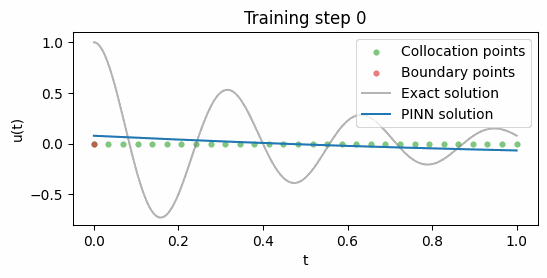

In [178]:
# Image(filename="pinn1.gif")
display(HTML('<img src="pinn1.gif" />')) # to display on github

---

## Task 2: train a PINN to invert for underlying parameters

---

### Task

The second task is to use a PINN to **invert** for underlying parameters.

Specifically, our inputs and outputs are:

- Inputs: noisy observations of the oscillator's displacement, $u_{\mathrm{obs}}$
- Outputs: estimate $\mu$, the coefficient of friction

### Approach

Similar to above, the PINN is trained to directly approximate the solution to the differential equation, i.e.

$$
N\!N(t;\theta) \approx u(t)~,
$$

However here we assume $\mu$ is **not known** and we treat it as an additional **learnable parameter** when training the PINN.

### Loss function

The PINN is trained with the loss function:

$$
\mathcal{L}(\theta, \mu)= \frac{1}{N} \sum^{N}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] N\!N(t_{i};\theta)  \right)^2 + \frac{\lambda}{M} \sum^{M}_{j} \left( N\!N(t_{j};\theta) - u_{\mathrm{obs}}(t_{j}) \right)^2
$$

In [152]:
# constants 
m = 1       # mass, kg
w0 = 20     # natural frequency, rad/s (sqrt(k/m))
k = w0**2   # spring constant, N/m
d = 2       # damping ratio (mu/(2m))
# mu = ?    # parameter to be learned

In [153]:
# instantiate a PINN
pinn = PINN(
    num_input=1,
    num_hidden=32,
    num_output=1, 
    num_layers=3,
    collocation=coll,
    boundary_conditions=bcs
    ).to(device)

# treat mu as a learnable parameter, add it to optimizer
mu = torch.nn.Parameter(torch.zeros(1, requires_grad=True))
optimizer = torch.optim.Adam(list(pinn.parameters())+[mu], lr=1e-3)

True value of mu: 4


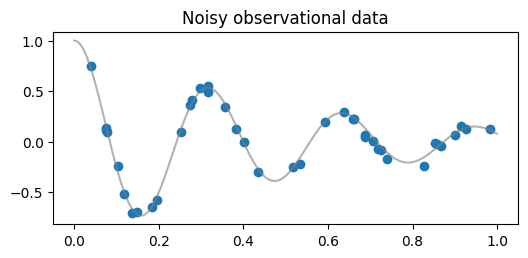

In [154]:
# first, create some noisy observational data
torch.manual_seed(123)
print(f"True value of mu: {2*d}")
t_obs = torch.rand(40).view(-1,1)
u_obs = exact_solution(d, w0, t_obs) + 0.04*torch.randn_like(t_obs)
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d, w0, t_test)

plt.figure(figsize=(6,2.5))
plt.title("Noisy observational data")
plt.scatter(t_obs[:,0], u_obs[:,0])
plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
plt.show()

In [155]:
def plot_result(u, t_obs, u_obs, t_test, mus, i):
    plt.figure(figsize=(12,2.5))
    
    plt.subplot(1,2,1)
    plt.scatter(t_obs[:,0], u_obs[:,0], label="Noisy observations", alpha=0.6, color="tab:blue")
    plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
    plt.title(f"Training step {i}")
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.title("$\mu$")
    plt.plot(mus, label="PINN estimate", color="tab:green")
    plt.hlines(2*d, 0, len(mus), label="True value", color="tab:grey")
    plt.xlabel("Training step")
    plt.legend()

In [156]:
torch.manual_seed(123)

# save the filenames of each plot frame
files = [] 

# save the value of mu at each step
mus = []

for i in range(15001):
    optimizer.zero_grad()
    
    # compute each term of the PINN loss function above
    # using the following hyperparameters
    lambda1 = 1e4
    
    # compute physics loss
    u = pinn(t_physics)# (30, 1)
    ut = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]# (30, 1)
    utt = torch.autograd.grad(ut, t_physics, torch.ones_like(ut), create_graph=True)[0]# (30, 1)
    loss1 = torch.mean((utt + mu*ut + k*u)**2)
    
    # compute data loss
    u = pinn(t_obs)
    loss2 = torch.mean((u - u_obs)**2)
    
    # backpropagate joint loss, take optimizer step
    loss = loss1 + lambda1*loss2
    loss.backward()
    optimizer.step()
    
    # record mu value
    mus.append(mu.item())

    print(f"loss: {loss.item():.4f}  | step: {i}", end="\r")
    
    # plot the result as training progresses
    if i % 150 == 0: 
        u = pinn(t_test)
        plot_result(
            u.detach().cpu(), 
            t_obs.detach().cpu(), 
            u_obs.detach().cpu(),
            t_test.detach().cpu(),
            mus,
            i
        )

        file = f"plots/pinn2_{i+1}.png"
        plt.savefig(file, bbox_inches="tight", pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        if (i+1) % 6000 == 0: plt.show()
        else: plt.close("all")
            
save_gif_PIL("pinn2.gif", files, fps=20, loop=0)

Saving 101 frames to pinn2.gif


In [182]:
display(HTML('<img src="pinn2.gif" />'))

---

## Task 3: PINN vs MLP 

---

### Task

The third task is to compare the performance of a PINN and an MLP at learning an oscillatory pattern from partial data. We'll use the same setup as in task 1, except this time we'll provide a few labeled training points at the beginning of the domain.

This is sort of an unfair comparison though. We give both the MLP and PINN the same labeled points along the exact solution, but then provide the PINN with additional collaction points. Anyway, the point is to show that given a few points, we can recover the desired solution better using a PINN.

In [167]:
# constants 
m = 1       # mass, kg
w0 = 20     # natural frequency, rad/s (sqrt(k/m))
k = w0**2   # spring constant, N/m
d = 2       # damping ratio (mu/(2m))
mu = 2*d*m  # damping coefficient, Ns/m

# store the coefficients for the highest order derivatives
coeffs = [k, mu, m]  # coefficientss on [u, ut, utt]

In [168]:
## IGNORE THIS CELL -- placeholder :) ##

# set the collocation points
coll = Collocation(t_physics, value=0.0, coefficients=coeffs, highest_order=2, reg_coeff=1e-4)

# set the boundary conditions
bc1 = BoundaryCondition(t_boundary, value=1.0, reg_coeff=1.0)
bc2 = BoundaryCondition(t_boundary, deriv_value=0.0, reg_coeff=1e-4)
bcs = [bc1, bc2]

In [169]:
# instantiate the PINN and MLP
pinn = PINN(
    num_input=1,
    num_hidden=32,
    num_output=1, 
    num_layers=3,
    collocation=coll,
    boundary_conditions=bcs
    ).to(device)
    
mlp = MLP(1, 32, 1, num_layers=3).to(device)

# set the optimizers
pinn_opt = torch.optim.Adam(pinn.parameters(),lr=1e-3)
mlp_opt = torch.optim.Adam(mlp.parameters(),lr=1e-3)

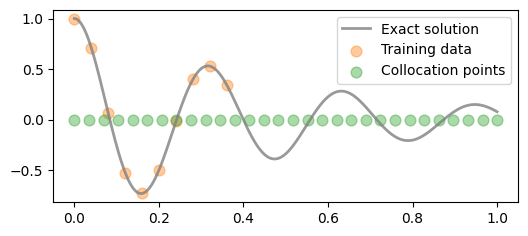

In [170]:
# first, create some noisy observational data
torch.manual_seed(123)
t = torch.linspace(0,1,500).view(-1,1)
u_exact = exact_solution(d, w0, t)

# get a sample of the exact solution
t_data = t[0:200:20]
u_data = u_exact[0:200:20] 

# get collocation points
t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)

# print(t.shape)
# print(u_exact.shape)
# print(t_data.shape)
# print(u_data.shape)

plt.figure(figsize=(6,2.5))
plt.plot(t[:,0], u_exact[:,0], color="grey", linewidth=2, alpha=0.8, label="Exact solution")
plt.scatter(t_data[:,0], u_data[:,0], s=60, color="tab:orange", alpha=0.4, label='Training data')
plt.scatter(t_physics.detach().cpu().numpy(), -0*torch.ones_like(t_physics.detach().cpu()), s=60, color="tab:green", alpha=0.4, label="Collocation points")
plt.legend()
plt.show()

In [171]:
def plot_result(pinn_out, mlp_out, t_physics, t_data, t, u_exact, i):
    plt.figure(figsize=(12, 2.5))  # Adjusted figure size to accommodate two subplots

    # subplot for MLP prediction
    plt.subplot(1, 2, 1)  
    plt.plot(t[:, 0], u_exact[:, 0], color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(t[:, 0], mlp_out, color="tab:blue", linewidth=4, alpha=0.8, label="MLP prediction")
    plt.scatter(t_data[:, 0], u_data[:, 0], s=60, color="tab:orange", alpha=0.4, label="Training data")
    plt.title(f"MLP Prediction at Step {i}")
    # set ylim -- the x lim is basically fixed
    plt.ylim(-0.8, 1.1)
    plt.xlabel("t")
    plt.ylabel("u(t)")
    plt.legend()

    # subplot for PINN prediction
    plt.subplot(1, 2, 2)  
    plt.plot(t[:, 0], u_exact[:, 0], color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(t[:, 0], pinn_out, color="tab:blue", linewidth=4, alpha=0.8, label="PINN prediction")
    plt.scatter(t_data[:, 0], u_data[:, 0], s=60, color="tab:orange", alpha=0.4, label="Training data")
    plt.scatter(t_physics, -0 * torch.ones_like(t_physics), s=60, color="tab:green", alpha=0.4, label="Collocation points")
    plt.title(f"PINN Prediction at Step {i}")
    plt.ylim(-0.8, 1.1)
    plt.xlabel("t")
    plt.ylabel("u(t)")
    plt.legend()

In [172]:
torch.manual_seed(123)
files = []

for i in range(15001):

    ### MLP optimization step ###
    mlp_opt.zero_grad()
    
    # MLP trains on the labeled data alone
    mlp_out = mlp(t_data)
    mlp_loss = torch.mean((mlp_out - u_data)**2)

    mlp_loss.backward()
    mlp_opt.step()


    ### PINN optimization step ####
    pinn_opt.zero_grad()
    
    # compute the labeled training data loss
    pinn_out = pinn(t_data)
    data_loss = torch.mean((pinn_out - u_data)**2)

    # compute physics loss
    u = pinn(t_physics)# (30, 1)
    ut = torch.autograd.grad(u, t_physics, torch.ones_like(u).to(device), create_graph=True)[0]# (30, 1)
    utt = torch.autograd.grad(ut, t_physics, torch.ones_like(ut), create_graph=True)[0]# (30, 1)
    phys_loss = torch.mean((utt + mu*ut + k*u)**2) # residual of the PDE
    
    # backpropagate joint loss, take optimizer step
    lam = 1e-4
    pinn_loss = data_loss + lam*phys_loss
    pinn_loss.backward()
    pinn_opt.step()
    
    print("i:", i, end="\r")
    # plot the result as training progresses
    if i % 150 == 0: 
        # get the output on the full t domain
        pinn_out = pinn(t)
        mlp_out = mlp(t)

        # pinn_out, mlp_out, t_physics, t_data, t, u_exact, i)
        plot_result(
            pinn_out = pinn_out.detach().cpu(), 
            mlp_out = mlp_out.detach().cpu(),
            t_physics = t_physics.detach().cpu(), 
            t_data = t_data.detach().cpu(),
            t = t.detach().cpu(),
            u_exact = u_exact.detach().cpu(),
            i=i
        )

        file = "plots/pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches="tight", pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        if (i+1) % 6000 == 0: plt.show()
        else: plt.close("all")
            
save_gif_PIL("pinn3.gif", files, fps=20, loop=0)

Saving 101 frames to pinn3.gif


In [181]:
display(HTML('<img src="pinn3.gif" />'))